# Assignment 1 16018942

## 2019-10-14

### Table of Contents
1. [Introduction](#introduction)
2. [Question 1](#question1)
3. [Question 2](#question2)

###### N.B Notebook runs in $\approx 100s$ and formatting has been checked with autopep8 (https://pypi.org/project/autopep8/)


## Introduction
<a id="introduction"></a>

In [2]:
# Importing the neccesary python libraries for the notebook.
import random
import multiprocessing
from multiprocessing import Pool
from functools import partial

# Importing the neccesary 3rd party libraries for the notebook.
import numpy as np
from numpy import linalg as LA
import numexpr as ne
from numba import njit
from numba import vectorize
import matplotlib.pyplot as plt

# Magic command to keep plots in the notebook.
%matplotlib inline

# Importing personal .py file.
# Contains functions for multiprocessing to use.
#import multiprocessfunctions as mpf

In [3]:
# Create timer for evaluating performance of algorithms.
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## Question 1
<a id="question1"></a>

Start by writing a function that is able to randomly update the position of the cursor (current place) on the lattice. I.e. adjust the x,y position corordinate by one of the four direction (+x,-x,+y,-y).

In [4]:
@njit
def new_cursor_position(x,y):                                                                                               
    '''Function that computes new position after one walk.
    Takes current cursor postion x,y corordinates as arguments
    '''
    direction = random.randint(1,4) #Faster than 'np.random.randint()'
    if direction == 1:
        y += 1
        return x, y
    elif direction == 2:
        x += 1
        return x, y
    elif direction == 3:
        y -= 1
        return x, y
    else:
        x -= 1
        return x, y

Python random library is used instead of numpy.random as it is marginly faster (at the cost of being less random but this not important for this application). Also I noticed that 'x = x+1' is slower than 'x += 1' so the faster practice is used throughout.

Then write function to verify if the cursor position is on a lattice edge.

In [5]:
@njit
def edge_detect(x_i,y_i, N):
    '''Function to check if cursor position is on lattice edge.
    Takes cursor position and size of square unit lattice as arguments.
    Returns 1,0,-1 to indicate edge detection or not.
    '''
    if y_i == 1:
        return 1
    elif y_i == N:
        return -1
    elif x_i == 1:
        return -1
    elif x_i == N:
        return -1
    else:
        return 0

Then write function to move the cursor. I.e. to simulate walking the cursor from a given start position on the lattice.

In [6]:
@njit
def random_walk_cursor(x_i,y_i,N):                                                                                                  
    '''Function for walking the cursor from the start position.
    A hard coded maximum step number for each walk is implemented.
    Returns Boolean for if the walk does or does not reach lattice
    edge.
    '''
    max_step = 1000
    current_step = 0
    while (current_step < max_step):
        if edge_detect(x_i,y_i,N) == 1:
            return True
        elif edge_detect(x_i,y_i,N) == 0:
            x_i, y_i = new_cursor_position(x_i, y_i)
            current_step += 1
        elif edge_detect(x_i,y_i,N) == -1:
            return False
    return False

Then final function to run the simulation of the cursor walking for a given number of times to try walking from each position.

In [7]:
@njit
def random_walk_across_lattice(lattice_size,walks_per_point):
    '''Function to simulate the cursor walking on the lattice.
    Arguments: size of square lattice, number of walks made by point.
    Returns array of walk completion probabilities for lattice positions.
    '''
    result_array = np.empty(shape=(lattice_size,lattice_size), dtype= np.float64)
    place_x = 1
    place_y = lattice_size
    while place_y >= 1:
        while place_x <= lattice_size:
            walk_number = 0
            sucesses = 0
            while walk_number < walks_per_point:
                result_of_walk = random_walk_cursor(place_x, place_y, lattice_size)                               
                if result_of_walk == True:
                    sucesses += 1
                walk_number += 1
            probability = sucesses/walks_per_point
            result_array[place_y-1, place_x-1] = probability
            place_x += 1
        place_y -= 1
        place_x = 1
    return result_array

Running the lattice walking simulation with a timer to measure the performance.

In [10]:
with Timer() as t:
    plot_data = random_walk_across_lattice(10,15)
print("Time to run walk: {0}s".format(t.interval))


Time to run walk: 0.004313230514526367s


Then we can plot a heatmap of the probabilities for the entire unit lattice.

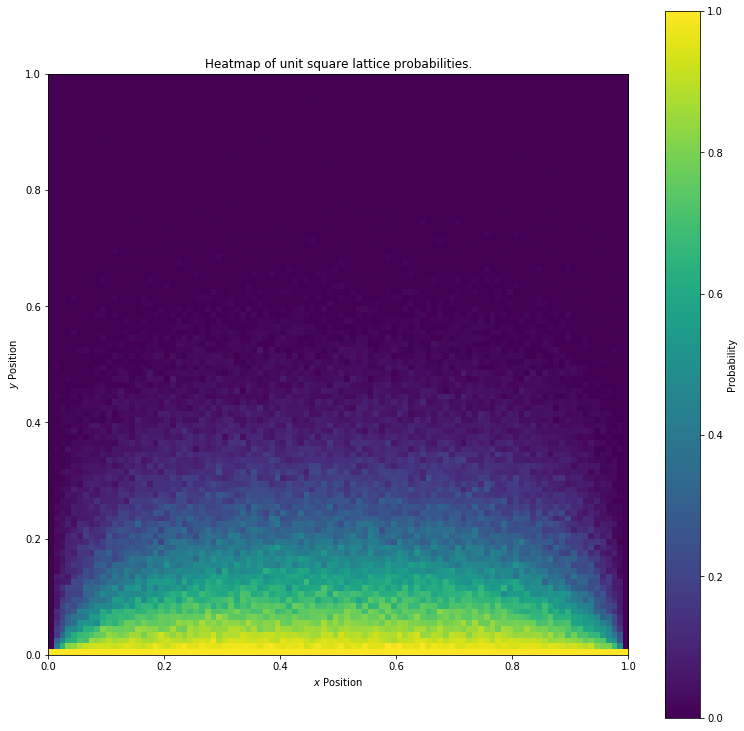

In [9]:
# Plotting method of data.
# Plot axis are modified to display for unit lattice.
plt.figure(figsize=(13,13))
plt.imshow(plot_data, cmap='viridis',origin ='lower',extent=[0,1,0,1])
plt.colorbar(label='Probability')
plt.title('Heatmap of unit square lattice probabilities.')
plt.xlabel('$x$ Position')
plt.ylabel('$y$ Position')
plt.show()

Using numba to optimise the walking on lattice simulation seems to have produced an optimised version. Also simplifying the loop structures, calculations and array operations to reduce the calculations has helped marginly increase the performance.

We can then try run the lattice walking simulation for different lattice sizes and examine the performance trend over time. The first magenta points were used to create the trendline, the last red point was used to verify the trendline.

In [ ]:
# Lattice simulation performance data.
lattice_values = [50,100,150,200]
timer_values = [2.02,27,93,219]

# Lattice simulation performance fit.
x_fit = np.linspace(0,1000,10000)
y_fit = 0.0082*x_fit**2-0.73*x_fit+18

# Plotting results
plt.figure(figsize=(15,4))
plt.plot(x_fit,y_fit,
         ':',label='Trendline 2nd order poly',color='skyblue')
plt.plot(lattice_values[0:3],timer_values[0:3],
         'o',label='Trend measurement',color='steelblue')
plt.plot(lattice_values[3:4],timer_values[3:4],
         'o',label='Trend verification',color='rebeccapurple')

plt.xlabel('Lattice size')
plt.ylabel('Time to procces s')
plt.legend()
plt.title('Performance as a function of lattice size')
plt.show()

From the heatmap of the simulation we can see that the probabnility distribution on the lattice is approximately symmetric about the mid point of the x positions on the lattice. This would then suggest that a massive performance increase could be gained by only computing probabilities for half of the x positions and then mirroring the probability data to show for the whole lattice. This also suggests that time to run the algorithm diverges as the lattice size tends to infinity.

In [ ]:
def random_walk_across_lattice_half(lattice_size,walks_per_point):
    '''Function to simulate the cursor walking on the halved lattice.
    Arguments: size of square lattice, number of walks made by point.
    Returns array of walk completion probabilities for half the lattice positions.
    '''
    lattice_size_half=int(lattice_size/2)
    result_array = np.empty(shape=(lattice_size,lattice_size_half), dtype= np.float64)
    place_x = 1
    place_y = lattice_size
    while place_y >= 1:
        while place_x <= lattice_size_half:
            walk_number = 0
            sucesses = 0
            while walk_number < walks_per_point:
                result_of_walk = random_walk_cursor(place_x, place_y, lattice_size)                               
                if result_of_walk == True:
                    sucesses += 1
                walk_number += 1
            probability = sucesses/walks_per_point
            result_array[place_y-1, place_x-1] = probability
            place_x += 1
        place_y -= 1
        place_x = 1
    return (np.concatenate((result_array,np.flip(result_array,axis=-1)),axis=-1))

Numba is not used here as array mirroring and merging in the return statement contains an unsupported function which Numba cannot work with. A workaround for this could be made by embedding part of 'random_walk_on_latticehalf' in an internal function which Numba is able to work with, but the performance gain from this is minimal and is therefore not done.

Running the lattice walking simulation with a timer to measure the performance.

In [ ]:
with Timer() as t:
    plot_data_half = random_walk_across_lattice_half(100,150)
print("Time to run walk: {0}s".format(t.interval))



In [ ]:
# Plotting method of data
# Plot axis are modified to display for unit lattice.
plt.figure(figsize=(13,13))
plt.imshow(plot_data_half, cmap='viridis',origin ='lower',extent=[0,1,0,1])
plt.colorbar(label='Probability')
plt.title('Heatmap of unit square lattice probabilities.')
plt.xlabel('$x$ Position')
plt.ylabel('$y$ Position')
plt.show()

As before we can examine the performance of this method over increasing lattice sizes.

In [ ]:
# Lattice simulation performance data.
lattice_values = [50,100,150,200]
timer_values = [2.02,27,93,219]

# Halved Lattice simulation performance data.
lattice_values_half = [50,100,150,200]
timer_values_half = [1.14,13.6,53.7,130]

# Lattice simulation performance fit.
x_fit = np.linspace(0,500,10000)
y_fit = 0.0082*x_fit**2-0.73*x_fit+18

# Halved Lattice simulation performance fit.
y_fit_half = 0.0055*x_fit**2-0.57*x_fit+16


# Plotting results.
plt.figure(figsize=(15,4))
plt.plot(x_fit,y_fit,
         ':',label='Normal: Trendline 2nd order poly',color='skyblue')
plt.plot(x_fit,y_fit_half,
         ':',label='Halved: Trendline 2nd order poly',color='maroon')
plt.plot(lattice_values[0:3],timer_values[0:3],
         'o',label='Normal: Trend measurement',color='steelblue')
plt.plot(lattice_values[3:4],timer_values[3:4],
         'o',label='Normal: Trend verification',color='rebeccapurple')
plt.plot(lattice_values_half[0:3],timer_values_half[0:3],
         'x',label='Halved: Trend measurement',color='coral')
plt.plot(lattice_values_half[3:4],timer_values_half[3:4],
         'x',label='Halved: Trend verification',color='fuchsia')

plt.xlabel('Lattice size')
plt.ylabel('Time to procces s')
plt.title('Algorithm performance comparison as a function of lattice size')
plt.legend()
plt.show()

The trendlines clearly show that the 'halved' algorithm is considerably faster. This is good but evidently comparing the heatmaps we can see that it is more approximative with regards to precision as we are infact simulating less walks. A comparison with the analytical solution for the probability distribution (http://mathworld.wolfram.com/PolyasRandomWalkConstants.html) would need to be made to definitively say how accurate the 'halved' algorithm is. Important to note that this method only works for even parity lattices. While the algorithm will produce a result for an odd parity lattice the results may or may not be correct as the value for half the lattice size is cast from a floating point to an integer and thus will be rounded and lose definiton.

We can similarly look at the trend for the number of walks for a fixed lattice size ($N=50$).

In [ ]:
# Lattice simulation performance data.
lattice_values_walks= [50,100,150,200,500,1000]
timer_values_walks = [0.59,1.13,1.8,2.3,5.7,11.59]

# Lattice simulation performance fit.
x_fit = np.linspace(0,1000,10000)

# Halved Lattice simulation performance fit.
y_fit_half_walks = 0.0121*x_fit-0.0367


# Plotting results.
plt.figure(figsize=(15,4))

plt.plot(x_fit,y_fit_half_walks,
         ':',label='Halved: Trendline linear regression',color='maroon')
plt.plot(lattice_values_walks[0:4],timer_values_walks[0:4],
         'o',label='Halved: Trend measurement',color='olive')
plt.plot(lattice_values_walks[4:6],timer_values_walks[4:6],
         'x',label='Halved: Trend verification',color='fuchsia')

plt.xlabel('Number of walks per position')
plt.ylabel('Time to procces s')
plt.title('Performance as a function of walk number for $N=50$')
plt.legend()
plt.show()

This would appear to indicate the the time to compute scales linearly with the number of walks per position for a given lattice size, this would appear to also diverge, but less strongly.

## Question 2
<a id="question2"></a>

Start by defining the functions in the question in the simplest possible way.

In [ ]:
# For convenience.
PI = np.pi

Represents function $u(x)$ in question. Numexpr and numpy are used to remove the need for looping over array alements which greatly increases performance.

In [ ]:
# This function is called from external .py file.
def potential(charge_position,test_position):
    '''Function for computing potential at a SINGLE test point. 
    Arguments are numpy arrays of charge points and test point.
    '''
    norm = LA.norm(ne.evaluate('charge_position-test_position'),axis=(test_position.ndim-1))
    potential = ne.evaluate('sum((1/(2*PI))*log(abs(norm)))')
    return potential

We use multiprocessing here to parallelize the computation of the potentials over the different test points thus each test point is computed against all charge points in for a given pool. Numexpr is again used to quickly sum the array elements.

In [ ]:
def multi_potential(test_position,charge_position):
    '''Function to multiprocess for all test points,x.
    Takes charges points as constant across pools.
    Arguments are test points and charge points in array.
    Returns potential sum for all test points.
    '''
    
    # Creates multiprocessing pool.
    pool = multiprocessing.Pool(processes=4)
    
    # Create partial function with constant charge_position array.
    partial_potential = partial(mpf.potential, charge_position)
    # Run multiprocessing on partial function for parallelised test_position array.
    sumpotential = pool.map(partial_potential, test_position)
    
    pool.close()
    pool.join()
    
    return ne.evaluate('sum(sumpotential)')
    

Represents the trapezoid approximation for function $f$ in the question. Numexpr and numpy are used to perform quick calculations on arrays to avoid using loops.

In [ ]:
def function_f(number_tests, number_charges, radius):
    '''Function to compute function in question
    sum without loops.
    Takes arguments of number of test points, number of charges
    and radius of test circle.
    '''
    unitcircleseed = np.linspace(0,PI*2,number_charges)
    circleseed = np.linspace(0,PI*2,number_tests)
    unitrandom = np.random.rand(1,number_charges)
    unitcirclepoints = np.array(
        [ne.evaluate('unitrandom*cos(unitcircleseed)'),
         ne.evaluate('unitrandom*sin(unitcircleseed)')]).T
    circlepoints = np.array(
        [ne.evaluate('radius*cos(circleseed)'),
         ne.evaluate('radius*sin(circleseed)')]).T
    potentialvalue = multi_potential(circlepoints,unitcirclepoints)
    return (1/(number_tests*number_charges))*potentialvalue

Then we can implement the function for $f$ and plot the results of which as a function of test circle radius. A time is used around the calling of the function (but not the plotting) to evaluate the performance.

In [ ]:
# Plotting f as function of r.
# Using timer to evaluate performance.
with Timer() as t:
    radius_array = np.arange(1,10)
    f_array = []
    for i in range(1,10): 
        f_array.append(function_f(1000,1000,i))
print("Time to run: {0}".format(t.interval))
plt.figure()
plt.plot(radius_array,f_array)
plt.xlabel('Radius of test point circle')
plt.ylabel('Function $f$')
plt.title('$f$ as a function of test circle radius')
plt.show()

Now similarly for finding the expectation value we define the neccesary functions first in a simple form.

In [ ]:
def expectation_value(radius, number_tests, number_charges):
    '''Function to find expectation value using function_sum2.
    Takes radius of test circle, number of test points and
    number of charges as arguments. Returns array of 
    expectation values.
    '''
    
    f = function_f(number_tests, number_charges, radius)
    u_0 = ne.evaluate('1/(2*PI)*log(radius)')
    
    return (f-u_0)/u_0

Then we can implement the function for e (expectation) and plot the results of which as a function of r. A time is used around the calling of the function (but not the plotting) to evaluate the performance.

In [ ]:
# Plotting e as function of r.
with Timer() as t:
    radius_array = np.arange(2,10)
    expectation_array = []
    for i in range(2,10): 
        expectation_array.append(expectation_value(i,1000,1000))
print("Time to run: {0}".format(t.interval))
plt.figure()
plt.plot(radius_array,expectation_array)
plt.xlabel('Radius of test point circle')
plt.ylabel('Expectation value')
plt.title('Expectation value as function test circle radius')
plt.show()

Ideally one would like to multiprocess, the for loop both here and the previous plot for $f$, over the different radii but it would appear that nesting the multiprocessing methods in this way is not possible. 

Then peform multiple trials with expectation value to find the convergence of the expectation value.

In [ ]:
# Plotting average e as function of r for multiple trials.
with Timer() as t:
    radius_array = np.arange(2,10)
    trials = 5
    trial_array = np.zeros((trials,8))
    
    # Loop for multiple trials.
    for m in range(0,trials):
        expectation_array = []
        for i in range(2,10): 
            expectation_array.append(expectation_value(i,1000,1000))
        trial_array[m]=expectation_array

dummy_array = ne.evaluate('sum(trial_array,axis=0)')
expectation_average = ne.evaluate('dummy_array/trials')

print("Time to run: {0}".format(t.interval))
plt.figure()
plt.plot(radius_array,expectation_average)
plt.xlabel('Radius of test point circle')
plt.ylabel('Expectation value')
plt.title('Average expectation value for %i trials' %trials)
plt.show()

It can be seen that by comparing the two plots the taking of mutiple trials and averaging the results produces essentially the same result which suggests that the number of random trials has little influence on the result. Interesting to note though is that running for 5 trials, the total time taken is less than 5 times that of a single trial (above). Ideally one would like to multiprocess the for loop here but it would appear that nesting the multiprocessing methods in this way is not possible. 

It also would appear from varying the number of test points and charge points that they tend to make the result smoother and more accurate as you increase them. This implies that increasing these parameters causes the expectation to converge.